In [1]:
import serial
import time
import torch
from datetime import datetime
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class BasicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BasicLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size*4)
        self.Drop = nn.Dropout(0.3)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.Drop(out)
        out = self.fc(out[:, -1, :])
        out = out.view(-1, 4, self.output_size)  # reshape the output to [batch_size, output_size, 4]
        out = out.permute(0, 2, 1)
        
        return out

In [64]:
def send_data(ser, pair):
    
    ser.flushInput()
    data = bytes(','.join(str(i) for i in pair) + '\n', 'utf-8')
    ser.write(data)
    
def extract_value(csv, upper_leg, lower_leg, idx):
    
    values = csv.iloc[idx].values.copy()
    values[:2] *= upper_leg
    values[2:] *= lower_leg
    
    # Safety Measures
    values[:2] = np.clip(values[:2], 0, upper_leg)
    values[2:] = np.clip(values[2:], 0, lower_leg)
    
    return [int(v) for v in values]

In [4]:
total = pd.read_csv("datasets/processed/total.csv").fillna(0, inplace=False)
total_left = total.iloc[:, :4]
total_right = total.iloc[:, 4:]
print(extract_value(total_left, 0))
display(total)

[9, 0, 9, 8]


,L_Quad: EMG 1 (IM) [V],L_Hamstring: EMG 2 (IM) [V],L_AntTib: EMG 3 (IM) [V],L_Calf: EMG 4 (IM) [V],R_Quad: EMG 5 (IM) [V],R_Hamstring: EMG 6 (IM) [V],R_AntTib: EMG 7 (IM) [V],R_Calf: EMG 8 (IM) [V]
0,0.111732,0.002260,0.111354,0.095514,0.082478,0.034568,0.014811,0.107523
1,0.106569,0.174243,0.440934,0.071500,0.120523,0.323094,0.035016,0.276876
2,0.085491,0.366960,0.077289,0.020765,0.142317,0.102857,0.052945,0.009403
3,0.099687,0.206314,0.367075,0.150406,0.181044,0.076396,0.017372,0.231190
4,0.006346,0.057149,0.011427,0.020112,0.161338,0.155786,0.071158,0.202951
...,...,...,...,...,...,...,...,...
3577,0.021143,0.145937,0.032054,0.004480,0.068054,0.466617,0.049029,0.071574
3578,0.000854,0.250712,0.057858,0.126241,0.016629,0.378969,0.034104,0.033434
3579,0.050638,0.073593,0.016769,0.033509,1.000000,0.156686,0.072951,0.065664
3580,0.059347,0.068247,0.024320,0.084355,0.176838,0.015171,0.037211,0.136361


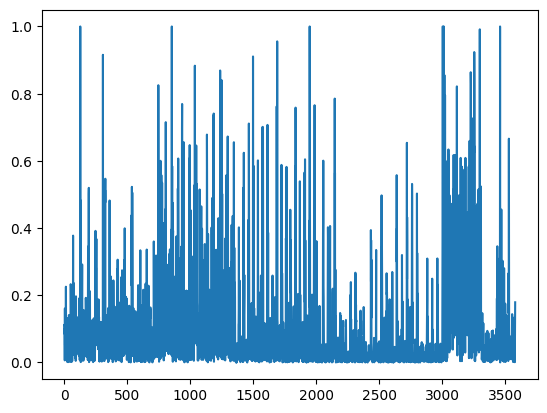

In [5]:
plt.plot(total_left.iloc[:,0].values)

In [6]:
def color_map(x):
    r = max(-np.e**(4*x-4)+1, 0)
    g = min(np.e**(8*x-4), 1)
    b = 0
    
    return (int(b*255),int(g*255),int(r*255))

In [7]:
#Leg Cords

ham_l_circle = (65, 200)
quad_l_circle = (220, 200)

anti_l_circle = (50, 500)
calve_l_circle = (185, 500)

ham_r_circle = (320, 200)
quad_r_circle = (490, 200)

anti_r_circle = (320, 500)
calve_r_circle = (455, 500)

circles_left = [quad_l_circle, ham_l_circle, calve_l_circle, anti_l_circle]
circles_right = [quad_r_circle, ham_r_circle, calve_r_circle, anti_r_circle]

BLACK = (0,0,0)

ser = serial.Serial('COM4', 9600)

In [67]:
model = BasicLSTM(4, 128, 5, 12)
model.load_state_dict(torch.load('models/EMG_P1.pt'))

leg_img = cv2.imread("legs.png")

count = 0

for _ in range(len(total[:3000])-1):
    t0 = datetime.now()
    
    upper_leg = 40
    lower_leg = 100
    
    values_left = extract_value(total_left, upper_leg, lower_leg, count)
    values_right = extract_value(total_right, upper_leg, lower_leg, count)
    
    send_data(ser, values_left)
    
    print(values_left, values_right, count)
    for c, v in zip(circles_left, values_left):
        
        d = upper_leg if v in values_left[:2] else lower_leg
        color = color_map(v/d)
        
        leg_img = cv2.circle(leg_img, c, 30, color, -1)
        leg_img = cv2.circle(leg_img, c, 33, BLACK, 5)
    
    for c, v in zip(circles_right, values_right):
        
        d = upper_leg if v in values_right[:2] else lower_leg
        color = color_map(v/d)
        
        leg_img = cv2.circle(leg_img, c, 30, color, -1)
        leg_img = cv2.circle(leg_img, c, 33, BLACK, 5)
    
    cv2.imshow("leg", leg_img)
    cv2.waitKey(1)
    
    # print(datetime.now() - t0)
    #print(values, count)
    
    time.sleep(0.022)
    # time.sleep(0.5)
    # print(datetime.now() - t0)
    
    count+=1
# ser.close()

[4, 0, 11, 9] [3, 1, 1, 10] 0
[4, 6, 44, 7] [4, 12, 3, 27] 1
[3, 14, 7, 2] [5, 4, 5, 0] 2
[3, 8, 36, 15] [7, 3, 1, 23] 3
[0, 2, 1, 2] [6, 6, 7, 20] 4
[6, 0, 10, 7] [2, 1, 0, 5] 5
[2, 0, 43, 27] [3, 8, 8, 6] 6
[6, 1, 39, 18] [3, 5, 4, 9] 7
[2, 1, 43, 18] [0, 1, 1, 27] 8
[2, 2, 21, 3] [4, 7, 7, 36] 9
[2, 0, 20, 1] [6, 10, 4, 26] 10
[5, 2, 20, 1] [12, 6, 7, 0] 11
[4, 2, 13, 2] [6, 1, 0, 9] 12
[9, 2, 5, 5] [2, 4, 4, 1] 13
[4, 4, 3, 16] [1, 1, 11, 5] 14
[5, 3, 3, 29] [3, 2, 17, 18] 15
[1, 4, 3, 56] [0, 4, 68, 3] 16
[2, 1, 0, 35] [0, 0, 18, 23] 17
[2, 0, 14, 5] [1, 2, 34, 4] 18
[4, 1, 2, 9] [1, 4, 15, 13] 19
[3, 1, 8, 5] [0, 0, 4, 6] 20
[0, 1, 2, 21] [2, 5, 0, 20] 21
[0, 0, 1, 3] [5, 5, 4, 7] 22
[0, 1, 14, 1] [5, 4, 23, 27] 23
[3, 2, 0, 8] [0, 3, 35, 20] 24
[0, 0, 0, 14] [2, 17, 26, 15] 25
[1, 3, 10, 18] [1, 8, 6, 13] 26
[4, 3, 4, 6] [0, 2, 13, 7] 27
[1, 4, 7, 36] [5, 5, 30, 6] 28
[5, 7, 1, 17] [4, 1, 6, 13] 29
[2, 0, 2, 16] [2, 0, 22, 17] 30
[5, 4, 5, 11] [4, 2, 7, 25] 31
[0, 4, 1, 5] [4, 5

In [51]:
send_data(ser, [0,0,0,0])

In [11]:
ser.close()

In [78]:
ser = serial.Serial('COM4', 9600)  # Replace COM4 with the port name of your Arduino
c = 0

while True:
    
    
    
    
    value = 30  # Replace 42 with the integer you want to send
    ser.flushInput()  # Clear the input buffer
    ser.write(value.to_bytes(2, 'big'))  # Convert the integer to bytes and send it
    
    time.sleep(2)  # Wait for 1 second before sending the next value
    
    
    value = 0  # Replace 42 with the integer you want to send
    ser.flushInput()  # Clear the input buffer
    ser.write(value.to_bytes(2, 'big'))  # Convert the integer to bytes and send it
    
    time.sleep(2)
    
    c+=1
    

KeyboardInterrupt: 